# Imports

In [ ]:
# Import of basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Sklearn imports
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import KFold, RandomizedSearchCV, train_test_split, cross_validate, cross_val_predict
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score, matthews_corrcoef, make_scorer, confusion_matrix

In [ ]:
# Import dataset
path ="https://github.com/KingKai69/VisualAnalytics/raw/main/Automobile_data.csv"
df = pd.read_csv(path)

# Rename target feature for better understanding
df.rename(columns={'symboling': 'risk-score'}, inplace=True)
df.head()

,risk-score,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.4,10.0,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.4,8.0,115,5500,18,22,17450


In [ ]:
df.describe()

,risk-score,wheel-base,length,width,height,curb-weight,engine-size,compression-ratio,city-mpg,highway-mpg
count,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000
mean,0.834146,98.756585,174.049268,65.907805,53.724878,2555.565854,126.907317,10.142537,25.219512,30.751220
std,1.245307,6.021776,12.337289,2.145204,2.443522,520.680204,41.642693,3.972040,6.542142,6.886443
min,-2.000000,86.600000,141.100000,60.300000,47.800000,1488.000000,61.000000,7.000000,13.000000,16.000000
25%,0.000000,94.500000,166.300000,64.100000,52.000000,2145.000000,97.000000,8.600000,19.000000,25.000000
50%,1.000000,97.000000,173.200000,65.500000,54.100000,2414.000000,120.000000,9.000000,24.000000,30.000000
75%,2.000000,102.400000,183.100000,66.900000,55.500000,2935.000000,141.000000,9.400000,30.000000,34.000000
max,3.000000,120.900000,208.100000,72.300000,59.800000,4066.000000,326.000000,23.000000,49.000000,54.000000


# Data Preprocessing

## Interpolation

In [ ]:
# Replace '?' values with NaN values for further preprocessing. 
df.replace('?', float('nan'), inplace=True)
# Check which columns contain NaN values.
df.isna().any()

risk-score           False
normalized-losses     True
make                 False
fuel-type            False
aspiration           False
num-of-doors          True
body-style           False
drive-wheels         False
engine-location      False
wheel-base           False
length               False
width                False
height               False
curb-weight          False
engine-type          False
num-of-cylinders     False
engine-size          False
fuel-system          False
bore                  True
stroke                True
compression-ratio    False
horsepower            True
peak-rpm              True
city-mpg             False
highway-mpg          False
price                 True
dtype: bool

In [ ]:
df.isna().sum()

risk-score            0
normalized-losses    41
make                  0
fuel-type             0
aspiration            0
num-of-doors          2
body-style            0
drive-wheels          0
engine-location       0
wheel-base            0
length                0
width                 0
height                0
curb-weight           0
engine-type           0
num-of-cylinders      0
engine-size           0
fuel-system           0
bore                  4
stroke                4
compression-ratio     0
horsepower            2
peak-rpm              2
city-mpg              0
highway-mpg           0
price                 4
dtype: int64

In [ ]:
# Replace NaN values for normalized losses with interpolation and of num-of-doors, bore, stroke, horsepower, peak-rm and price with mode of respectiuve column

# Create new dataframe
df_imp = df.copy()

# Interpolation
df_imp['normalized-losses'] = df_imp['normalized-losses'].astype('float32')
df_imp['normalized-losses'] = df_imp[['normalized-losses']].interpolate(method="pad")

# Impute remaining NaN Values with mode of respective column
df_imp = df_imp.fillna(df_imp.mode().iloc[0])

## Label Encoding

In [ ]:
# Init new LabelEncoder object
le = LabelEncoder()

# Init dataframe for encoded data
df_enc = df_imp.copy()

# Encoding of columns with categorical data
columns_to_encode = ['make', 'fuel-type', 'aspiration', 'num-of-doors', 'body-style', 'drive-wheels', 'engine-location','engine-type','num-of-cylinders','fuel-system'] 
encoding_mapping = {}
for column in columns_to_encode:
    df_enc[column] = le.fit_transform(df_enc[column])
    encoding_mapping[column] = dict(zip(le.classes_, le.transform(le.classes_)))

#df_enc.head()

In [ ]:
# Create dataframes for each feature with original value and encoded value
for feature, mapping in encoding_mapping.items():
    df_data = []
    for category, encoded_value in mapping.items():
        df_data.append({'Origin label': category, 'Encoded label': encoded_value})
    
    df = pd.DataFrame(df_data)
    df_name = f"{feature}_df"
    globals()[df_name] = df

In [ ]:
# Show dataframe of feature make
make_df.head()

,Origin label,Encoded label
0,alfa-romero,0
1,audi,1
2,bmw,2
3,chevrolet,3
4,dodge,4


In [ ]:
# Changes dtypes of columns from object to int64 respective float 64. 
for col in df_enc.columns:
    if df_enc[col].dtype == 'object':
        try:
            df_enc[col] = df_enc[col].astype('int64')
        except ValueError:
            try:
                df_enc[col] = df_enc[col].astype('float64')
            except ValueError:
                pass  

print(df_enc.dtypes)

risk-score             int64
normalized-losses    float32
make                   int64
fuel-type              int64
aspiration             int64
num-of-doors           int64
body-style             int64
drive-wheels           int64
engine-location        int64
wheel-base           float64
length               float64
width                float64
height               float64
curb-weight            int64
engine-type            int64
num-of-cylinders       int64
engine-size            int64
fuel-system            int64
bore                 float64
stroke               float64
compression-ratio    float64
horsepower             int64
peak-rpm               int64
city-mpg               int64
highway-mpg            int64
price                  int64
dtype: object


## Scaling

In [ ]:
# Create df without target
df_features = df_enc.drop(['risk-score'], axis=1)

# Init new StandardScaler object
scaler = StandardScaler()

# Fit scaler
scaled_data = scaler.fit_transform(df_features)
df_sc = pd.DataFrame(scaled_data, columns=df_features.columns)

# Append target to scaled data
df_sc['risk-score'] = df_enc['risk-score']

## Correlation analysis

In [ ]:
# Create list of all possible features (25)
features = [
    'normalized-losses',
    'make',
    'fuel-type',
    'aspiration',
    'num-of-doors',
    'body-style',
    'drive-wheels',
    'engine-location',
    'wheel-base',
    'length',
    'width',
    'height',
    'curb-weight',
    'engine-type',
    'num-of-cylinders',
    'engine-size',
    'fuel-system',
    'bore',
    'stroke',
    'compression-ratio',
    'horsepower',
    'peak-rpm',
    'city-mpg',
    'highway-mpg',
    'price',
]

<Axes: >

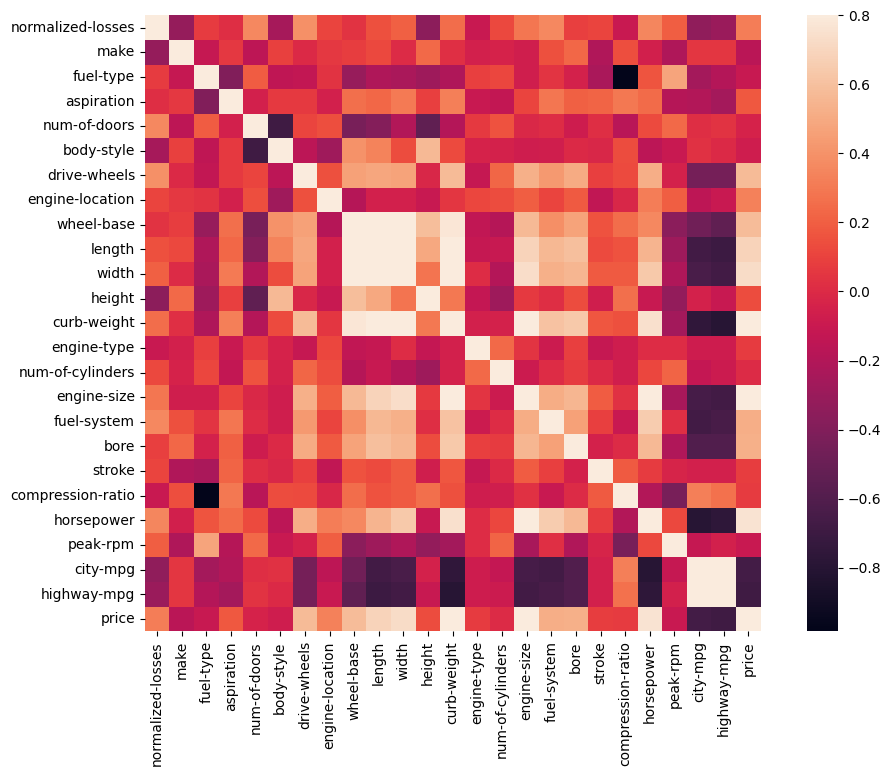

In [ ]:
# Create correlation matrix
Val = df_enc[features]
corrmat = Val.corr(numeric_only=True)
f, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(corrmat, vmax=.8, square=True)

In [ ]:
# Create df with high correlated feature pairs
corrmat_masked = corrmat.mask(abs(corrmat) >= 1)

# Filter correlation above/below 0.7/-0.7
high_corr = corrmat_masked[(corrmat_masked > 0.7) | (corrmat_masked < -0.7)].stack().reset_index()
high_corr.columns = ['Feature_A', 'Feature_B', 'Correlation']

# Remove duplicates
high_corr = high_corr[high_corr['Feature_A'] < high_corr['Feature_B']]
high_corr.head(n=120)

,Feature_A,Feature_B,Correlation
2,wheel-base,width,0.795144
4,length,wheel-base,0.874587
5,length,width,0.841118
13,curb-weight,wheel-base,0.776386
14,curb-weight,length,0.877728
15,curb-weight,width,0.867032
16,curb-weight,engine-size,0.850594
17,curb-weight,horsepower,0.748539
19,curb-weight,highway-mpg,-0.797465
20,curb-weight,price,0.820807


# Modelling

In [ ]:
# Create 3 classification label and check for imbalance
df_enc_3 = df_enc.copy()
df_enc_3['risk-score'] = df_enc_3['risk-score'].replace(3, 'high-risk')
df_enc_3['risk-score'] = df_enc_3['risk-score'].replace(2, 'high-risk')
df_enc_3['risk-score'] = df_enc_3['risk-score'].replace(1, 'medium-risk')
df_enc_3['risk-score'] = df_enc_3['risk-score'].replace(0, 'medium-risk')
df_enc_3['risk-score'] = df_enc_3['risk-score'].replace(-1, 'low-risk')
df_enc_3['risk-score'] = df_enc_3['risk-score'].replace(-2, 'low-risk')
pd.value_counts(df_enc_3['risk-score'])

medium-risk    121
high-risk       59
low-risk        25
Name: risk-score, dtype: int64

In [ ]:
# Check distribution of classification labels in test set to verify same distribution as in origin data set
labels = ['high-risk', 'medium-risk', 'low-risk']

# Init counter
counter = {label: 0 for label in labels}

# Count elements in list
for element in y_test:
    if element in counter:
        counter[element] += 1

# print results
for feature, num in counter.items():
    share = num / len(y_test)
    print(f"'{feature}' occurs {num} times. Share of total: {share:.2%}")

# Same share than in origin data

'high-risk' occurs 15 times. Share of total: 28.85%
'medium-risk' occurs 31 times. Share of total: 59.62%
'low-risk' occurs 6 times. Share of total: 11.54%


In [ ]:
# Create list of features
features_nonCor = [
    'normalized-losses',
    'make',
    'fuel-type',
    'aspiration',
    'num-of-doors',
    'body-style',
    'drive-wheels',
    'engine-location',
    'height',
    'curb-weight',
    'engine-type',
    'num-of-cylinders',
    'fuel-system',
    'bore',
    'stroke',
    'horsepower',
    'peak-rpm',
    'city-mpg',
]

In [ ]:
# Fixing the SEED
SEED = 27

In [ ]:
# Define X and Y data, both for scaled and non scaled data
x_data = df_enc_3[features_nonCor]
y_data = df_enc_3['risk-score']

x_data_s = df_sc[features_nonCor]
y_data_s = df_sc['risk-score']

In [ ]:
# Train Test Split for non scaled data
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.25, random_state=SEED, stratify=y_data)

# Train Test for scaled data
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(x_data_s, y_data_s, test_size=0.25, random_state=SEED, stratify=y_data)

In [ ]:
# Init KFold for cross validation
kf_cv = KFold(n_splits = 5, shuffle = True, random_state=SEED)

# Spot Checking

In [ ]:
# Definitions of metric
scorings = {
    'f1_score': make_scorer(f1_score, average='weighted', zero_division=1), 
    'mcc': make_scorer(matthews_corrcoef),
    }

In [ ]:
# Definition of models for spot checking
def get_models():
    models=[
       ('Decision Tree',DecisionTreeClassifier(random_state = SEED)),
       ('Random Forest',RandomForestClassifier(random_state = SEED)),
       ('Extremely Randomized Trees',ExtraTreesClassifier(random_state = SEED)),
       ('Ada Boost',AdaBoostClassifier(random_state = SEED)),
       ('Gradient Boosting',GradientBoostingClassifier(random_state = SEED)),
       ('Support Vector Machine', SVC()),   
       ('Naive Bayes', GaussianNB()),    
       ('KNN', KNeighborsClassifier()),    
       ('Support Vector Machine', SVC()),
       ('Multilayer Perceptron',MLPClassifier(max_iter = 1000, random_state = SEED)),
    ]
    return models

## Non scaled data

In [ ]:
# Load models
models = get_models()

# Create list for scores
all_cv_scores = []

# Iter through our list of models and perform cross validation
for name, clf in tqdm(models):
    
    # Init dict for results of classifiert 
    formatted_result = {}
    formatted_result['Classifier'] = name

    # Perform cross valiation 
    cv_score  = cross_validate(estimator = clf, X = X_train, y = y_train, cv = kf_cv, scoring = scorings)

    # Add mean score and standard deviation to dictionary
    for score_name, scores in cv_score.items():
        # Add the completely prepared string 
        formatted_result[f'{score_name}_mean'] = np.mean(scores)
        formatted_result[f'{score_name}_std'] = np.std(scores)
        
    # Add dict to final scores list
    all_cv_scores.append(formatted_result)

100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


In [ ]:
pd.DataFrame(all_cv_scores)

,Classifier,fit_time_mean,fit_time_std,score_time_mean,score_time_std,test_f1_score_mean,test_f1_score_std,test_mcc_mean,test_mcc_std
0,Decision Tree,0.002915,0.001089,0.004315,0.002621,0.838354,0.094193,0.712432,0.172235
1,Random Forest,0.121189,0.011923,0.011366,0.000397,0.864584,0.091629,0.762860,0.148462
2,Extremely Randomized Trees,0.089919,0.002144,0.012128,0.001170,0.865519,0.112161,0.768472,0.181650
3,Ada Boost,0.064170,0.002423,0.010739,0.002327,0.708284,0.061433,0.463123,0.144774
4,Gradient Boosting,0.241617,0.008427,0.004664,0.000482,0.863663,0.097877,0.772898,0.142895
5,Support Vector Machine,0.003956,0.002144,0.003854,0.000710,0.438752,0.095483,0.000000,0.000000
6,Naive Bayes,0.002111,0.000287,0.003107,0.000107,0.670713,0.059593,0.447577,0.090928
7,KNN,0.001952,0.000134,0.018083,0.026401,0.653965,0.113828,0.373530,0.215383
8,Support Vector Machine,0.002705,0.000254,0.003270,0.000104,0.438752,0.095483,0.000000,0.000000
9,Multilayer Perceptron,0.016881,0.005574,0.004016,0.000532,0.419834,0.092997,0.094029,0.082304


## Scaled data

In [ ]:
# Load models
models = get_models()

# Create list for scores
all_cv_scores_s = []

# Iter through our list of models and perform cross validation
for name, clf in tqdm(models):
    
    # Init dict for results of classifier 
    formatted_result = {}
    formatted_result['Classifier'] = name

    # Perform cross validation 
    cv_score  = cross_validate(estimator = clf, X = x_data_s, y = y_data_s, cv = kf_cv, scoring = scorings)

    # Add mean score and standard deviation to dictionary
    for score_name, scores in cv_score.items():
        # Add the completely prepared string 
        formatted_result[f'{score_name}_mean'] = np.mean(scores)
        formatted_result[f'{score_name}_std'] = np.std(scores)

    # Add dict to final scores list
    all_cv_scores_s.append(formatted_result)

100%|██████████| 10/10 [00:08<00:00,  1.21it/s]


In [ ]:
pd.DataFrame(all_cv_scores_s)

,Classifier,fit_time_mean,fit_time_std,score_time_mean,score_time_std,test_f1_score_mean,test_f1_score_std,test_mcc_mean,test_mcc_std
0,Decision Tree,0.002818,0.000994,0.003462,0.000925,0.739796,0.070291,0.661564,0.088331
1,Random Forest,0.117735,0.002155,0.012804,0.000985,0.782588,0.060083,0.718693,0.073047
2,Extremely Randomized Trees,0.091644,0.002082,0.012171,0.000386,0.784353,0.070961,0.721982,0.082930
3,Ada Boost,0.066182,0.005520,0.010445,0.001942,0.441867,0.078558,0.330502,0.053788
4,Gradient Boosting,0.498404,0.042984,0.004307,0.000180,0.779269,0.056664,0.715979,0.077763
5,Support Vector Machine,0.003445,0.000261,0.003419,0.000109,0.671124,0.062358,0.579616,0.059195
6,Naive Bayes,0.002042,0.000117,0.003241,0.000086,0.446899,0.056965,0.394364,0.063622
7,KNN,0.001684,0.000107,0.005141,0.000141,0.600947,0.052411,0.490599,0.060874
8,Support Vector Machine,0.003171,0.000205,0.003446,0.000283,0.671124,0.062358,0.579616,0.059195
9,Multilayer Perceptron,0.796751,0.281735,0.005620,0.001607,0.742459,0.062174,0.658885,0.073811


# Hyperparametertuning

## Randomized Search

In [ ]:
# Init best model for hyperparametertuning
model = ExtraTreesClassifier(class_weight='balanced', random_state = SEED)

# define parameter space
param_dist = {
              'n_estimators': np.arange(50, 501, 10),
              "criterion": ["gini", "entropy", 'log_loss'],
              "max_depth": np.arange(1, 26, 1),
              "min_samples_split": np.arange(1, 26, 1),
              "min_samples_leaf": np.arange(1, 26, 1),
              "max_features": ["sqrt", "log2", None], 
              "bootstrap": [True, False],
              }

# Init optimizer
hyperparam_optimizer = RandomizedSearchCV(estimator = model, # The estimator or pipeline we want to optimize
                                          param_distributions = param_dist, # Our parameter grid
                                          n_iter = 25, # Searches for 10 random combinations
                                          n_jobs = -1, # Use all available CPU cores
                                          scoring = "f1_weighted", # Name of the scorer used for 
                                          cv = kf_cv # The CrossValidation to use
                                          )

In [ ]:
# Fit the randomized search object
hyperparam_optimizer.fit(X_train, y_train)

# Print best parameters and score
print("Best parameters found: ", hyperparam_optimizer.best_params_)
print("Best F1 score found: ", hyperparam_optimizer.best_score_)

# Evaluation 5 fold cross validation (seen data)

Durchschnittlicher F1-Score: 0.86
Standardabweichung des F1-Scores: 0.09


Text(70.72222222222221, 0.5, 'Actual')

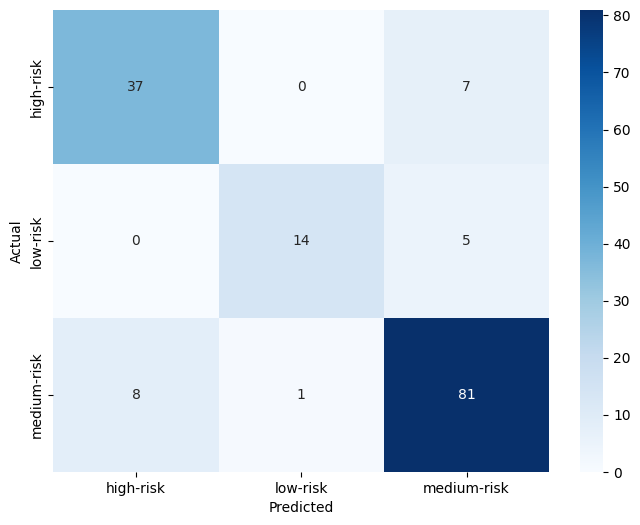

In [ ]:
# Init new classifier with best setting of Hyperparameters
clf_final = ExtraTreesClassifier(n_estimators=301, criterion="gini", max_depth=12 , max_features='sqrt', min_samples_split=5, min_samples_leaf=1, bootstrap=False, class_weight='balanced', random_state = SEED)

scoring = {'f1_score': make_scorer(f1_score, average='weighted', zero_division=1)}

cv_final = cross_validate(estimator = clf_final, X = X_train, y = y_train, cv = kf_cv, scoring = scoring)

f1_scores_cv = cv_final['test_f1_score']

# Calculate mean F1_score
mean_f1_score_cv = np.mean(f1_scores_cv)
std_f1_score_cv = np.std(f1_scores_cv)

# Create confusion matrix
y_pred_cv = cross_val_predict(clf_final, X_train, y_train, cv=kf_cv)
cm_cv = confusion_matrix(y_train, y_pred_cv)

# Print results
print("Durchschnittlicher F1-Score: {:.2f}".format(mean_f1_score_cv))
print("Standardabweichung des F1-Scores: {:.2f}".format(std_f1_score_cv))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_cv, annot=True, cmap='Blues', fmt='d', xticklabels=['high-risk','low-risk','medium-risk'], yticklabels=['high-risk','low-risk','medium-risk'])
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Evaluation of test data (unseen data)

In [ ]:
# Fit the model
clf_final.fit(X_train, y_train)

# Create predictions
y_pred_final = clf_final.predict(X_test)

# Calculate F1score
f1_final = f1_score(y_test, y_pred_final, average='weighted', zero_division=1)
print("F1-Score: {:.2f}".format(f1_final))

F1-Score: 0.89


Text(70.72222222222221, 0.5, 'Actual')

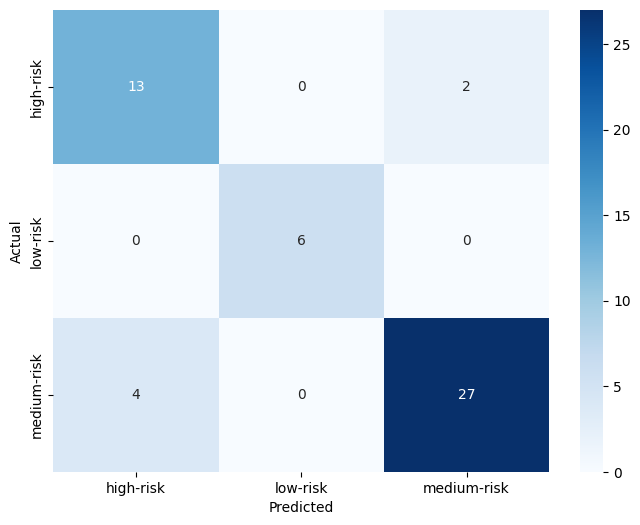

In [ ]:
# Plot confusion matrix
cm_final = confusion_matrix(y_test, y_pred_final)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_final, annot=True, cmap='Blues', fmt='d', xticklabels=clf_final.classes_, yticklabels=clf_final.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Explainable AI

In [ ]:
# Create dataframe with prediction results
df_results = pd.DataFrame({'Test Labels': y_test, 'Predicted Labels': y_pred_final})
df_results.describe()

,Test Labels,Predicted Labels
count,52,52
unique,3,3
top,medium-risk,medium-risk
freq,31,29


In [ ]:
# Create df with false classification results. In addition the feature values are appended.

df_exp = pd.concat([X_test, df_results], axis=1)
df_exp_false = df_exp[df_exp['Test Labels'] != df_exp['Predicted Labels']]
df_exp_false.loc[:, 'iloc_xtest'] = [21, 29, 31, 38, 45, 50]
new_order = ['Test Labels', 'Predicted Labels', 'iloc_xtest'] + list(df_exp_false.columns[:18])
df_exp_false = df_exp_false[new_order]

In [ ]:
df_exp_false.head()

,Test Labels,Predicted Labels,iloc_xtest,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,...,height,curb-weight,engine-type,num-of-cylinders,fuel-system,bore,stroke,horsepower,peak-rpm,city-mpg
2,medium-risk,high-risk,29,161,0,1,0,1,2,2,...,52.4,2823,5,3,5,2.68,3.47,154,5000,19
69,medium-risk,high-risk,31,93,9,0,1,1,1,2,...,54.9,3495,3,1,3,3.58,3.64,123,4350,22
3,high-risk,medium-risk,38,164,1,1,0,0,3,1,...,54.3,2337,3,2,5,3.19,3.40,102,5500,24
98,high-risk,medium-risk,45,168,12,1,0,1,1,1,...,53.3,2008,3,2,1,3.15,3.29,69,5200,31
75,medium-risk,high-risk,50,161,10,1,1,1,2,2,...,54.8,2910,3,2,5,3.78,3.12,175,5000,19


In [ ]:
# Create dataframes for correct classifications both for class medium-risk and high-risk

df_exp_corr = df_exp[df_exp['Test Labels'] == df_exp['Predicted Labels']]
df_exp_corr_hr = df_exp[(df_exp['Test Labels'] == 'high-risk') & (df_exp['Predicted Labels'] == 'high-risk')]
df_exp_corr_mr = df_exp[(df_exp['Test Labels'] == 'medium-risk') & (df_exp['Predicted Labels'] == 'medium-risk')]


In [ ]:
# Count values for specific feature
feature = 'make'
counts_mr = df_exp_corr_mr[feature].value_counts()
counts_hr = df_exp_corr_hr[feature].value_counts()

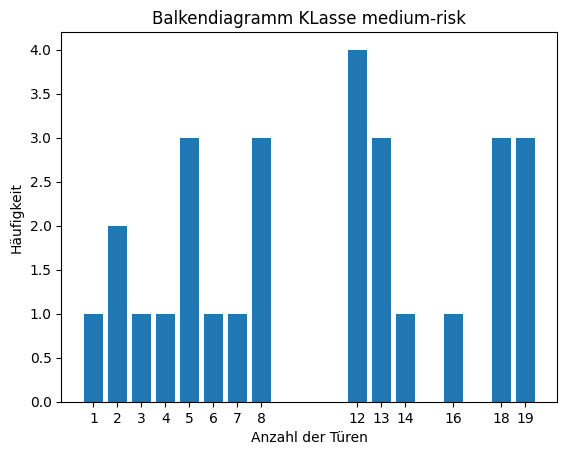

In [ ]:
# Plot the counts for specific features
plt.bar(counts_mr.index, counts_mr.values)
plt.xlabel('Anzahl der Türen')
plt.ylabel('Häufigkeit')
plt.title('Balkendiagramm KLasse medium-risk')
plt.xticks(counts_mr.index)
plt.show()

In [ ]:
# Create mean values for numerous features of correct predictions
mean_val_corr_mr = df_exp_corr_mr['normalized-losses'].mean()
mean_val_corr_hr = df_exp_corr_hr['normalized-losses'].mean()

print(mean_val_corr_mr)
print(mean_val_corr_hr)

126.92857142857143
156.84615384615384


# SHAP

In [ ]:
pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 10.0 MB/s eta 0:00:00


In [ ]:
import shap

## Compute Shap Values

In [ ]:
# Init Shap Tree Explainer
explainer_tree = shap.TreeExplainer(clf_final)

# Explain X_test with SHAP
shap_values_tree = explainer_tree.shap_values(X_test)

## Force Plots

In [ ]:
# Explain Single prediction from test set
iloc = 50
shap.initjs()


shap.force_plot(explainer_tree.expected_value[0], shap_values_tree[0][iloc], X_test.iloc[iloc,:])
#############################
##### Class 0 High risk #####
#############################

In [ ]:
shap.initjs()
shap.force_plot(explainer_tree.expected_value[1], shap_values_tree[1][iloc], X_test.iloc[iloc,:])

#############################
##### Class 1 low risk ######
#############################

In [ ]:
shap.initjs()
shap.force_plot(explainer_tree.expected_value[2], shap_values_tree[2][iloc], X_test.iloc[iloc,:])

###############################
##### Class 2 medium risk #####
###############################

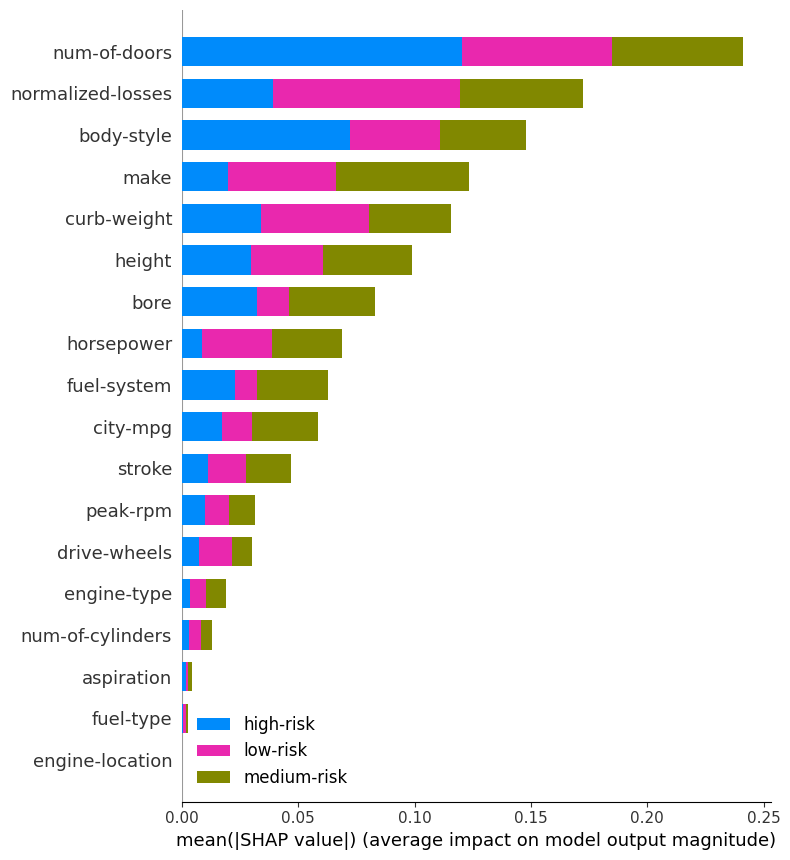

In [ ]:
shap.summary_plot(shap_values_tree, X_test, class_inds="original", class_names=clf_final.classes_)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


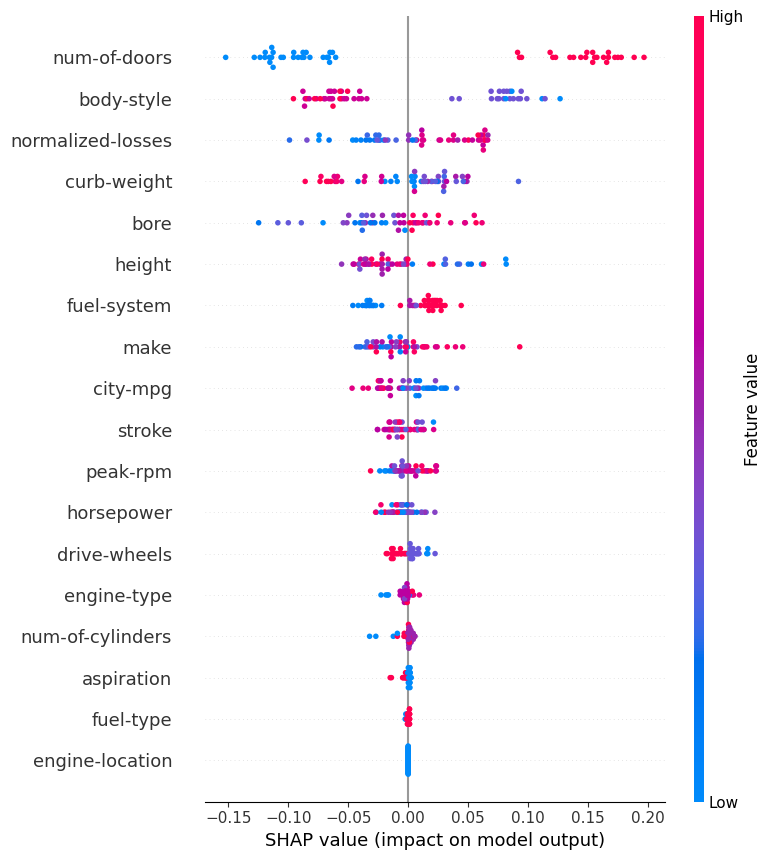

In [ ]:
# Summary Plot 'high-risk'
shap.summary_plot(shap_values_tree[0], X_test)

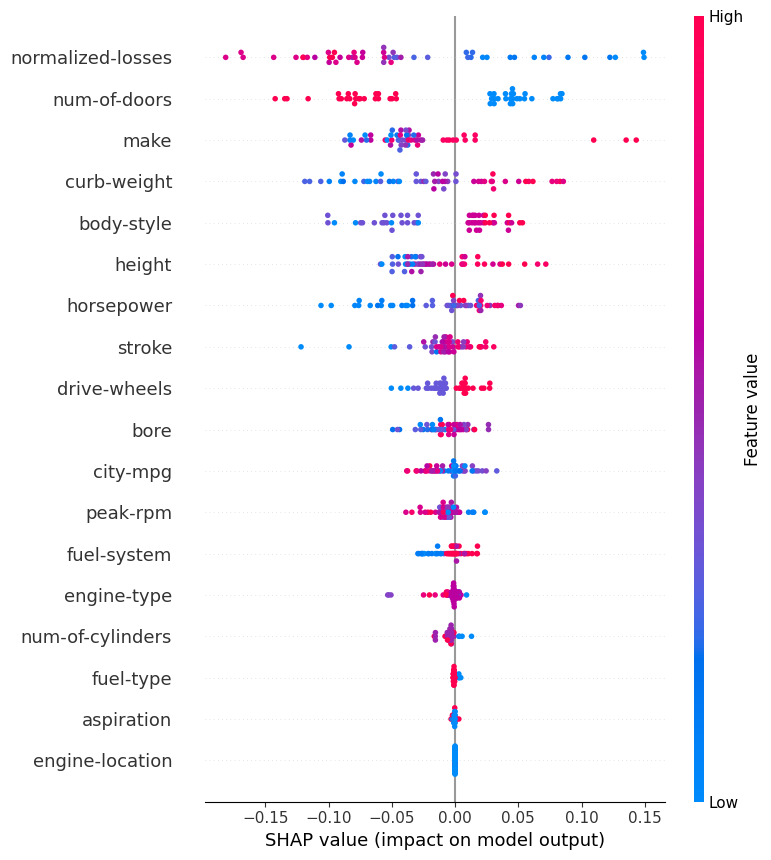

In [ ]:
# Summary plot low risk
shap.summary_plot(shap_values_tree[1], X_test)

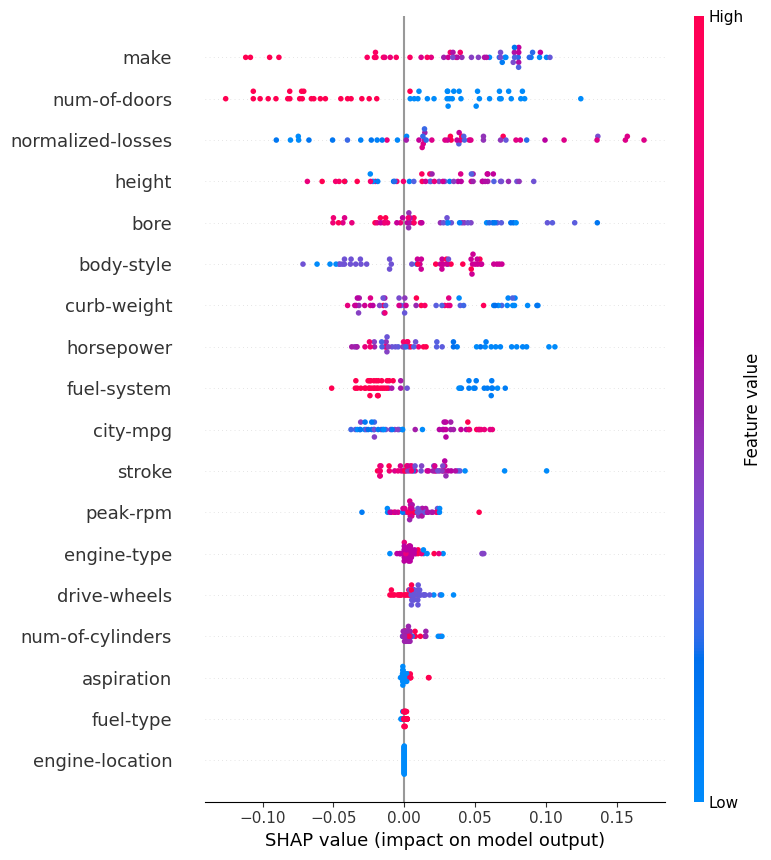

In [ ]:
# Summary plot 'medium-risk'
shap.summary_plot(shap_values_tree[2], X_test)